# Optuna Optimizer
## How to perform cross validation and hiperparameter optimization with Optuna.

If you have seen the tutorial [Reuse Data](notebooks/caching_heavy_data.ipynb) you mai noticed that we've use a standard sklean optimizer for hyperparameter tuning. This is fine for many uses cases, but it might not be the best choice for somo others. For those how need a more advanced optimization strategy, Optuna is a great choice.

### We will use the same pipeline as before.

In [1]:
from framework3.utils.patch_type_guard import patch_inspect_for_notebooks

patch_inspect_for_notebooks()

✅ Patched inspect.getsource using dill.


In [2]:
from sklearn.datasets import fetch_20newsgroups

# Cargar el conjunto de datos 20 Newsgroups
train = fetch_20newsgroups(subset="train")
test = fetch_20newsgroups(subset="test")

In [3]:
from framework3.base import XYData


X_train = XYData(
    _hash="20NG train X",
    _path="/datasets",
    _value=train.data,  # type: ignore
)
X_test = XYData(
    _hash="20NG test X",
    _path="/datasets",
    _value=test.data,  # type: ignore
)
y_train = XYData(
    _hash="20NG train y",
    _path="/datasets",
    _value=train.target,  # type: ignore
)
y_test = XYData(
    _hash="20NG test y",
    _path="/datasets",
    _value=test.target,  # type: ignore
)

In [4]:
from framework3.plugins.filters.llm import HuggingFaceSentenceTransformerPlugin

llm = HuggingFaceSentenceTransformerPlugin(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

### Then we will configure Optuna for hyperparameter tuning and a Sklearn splitter for cross validation.

Optuna provides a dashboard to visualize the results of the experiments. For this to work, you need to define an sqlite storage path. Also, each study meed a name and the optimizer need a direction for the optimization.

In [8]:
from framework3 import F1, ClassifierSVMPlugin, Precission, Recall
from framework3.plugins.optimizer.optuna_optimizer import OptunaOptimizer
from framework3.plugins.filters import PCAPlugin
from framework3.plugins.pipelines.sequential import F3Pipeline
from framework3.plugins.splitter import KFoldSplitter


grid_pipelin = (
    F3Pipeline(
        filters=[
            PCAPlugin().grid({"n_components": [10, 100]}),
            ClassifierSVMPlugin(kernel="rbf").grid(
                {"C": [0.1, 10.0], "gamma": (0.001, 0.0001)}
            ),
        ],
        metrics=[F1(), Precission(), Recall()],
    )
    .splitter(KFoldSplitter(n_splits=2, shuffle=True))
    .optimizer(
        OptunaOptimizer(
            n_trials=10,
            direction="maximize",
            study_name="20 NG",
            load_if_exists=True,
            storage="sqlite:///optuna_estudios.db",
        )
    )
)

[I 2025-04-15 18:36:58,503] Using an existing study with name '20 NG' instead of creating a new one.


Now we can search for the best hyperparameters.

In [9]:
from framework3 import Cached, Precission, Recall

final_pipeline = F3Pipeline(
    filters=[Cached(llm, cache_data=True, cache_filter=False), grid_pipelin],
    metrics=[F1(), Precission(), Recall()],
)

In [10]:
final_pipeline.fit(X_train, y_train)
_y = final_pipeline.predict(X_test)

____________________________________________________________________________________________________
Fitting pipeline...
****************************************************************************************************

*Cached({'filter': HuggingFaceSentenceTransformerPlugin({'model_name': 
'sentence-transformers/all-mpnet-base-v2'}), 'cache_data': True, 'cache_filter': False, 'overwrite': False, 
'storage': None})

- El filtro HuggingFaceSentenceTransformerPlugin({'model_name': 
'sentence-transformers/all-mpnet-base-v2'}) con hash cd52a2089d77df27ae1a888d97422cd38e3bb01a No existe, se va a 
entrenar.

- El dato XYData(_hash='0bb5f0568e0be233f4dfc5bbe7e893a6369f353e', 
_path='HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a') No existe, se va a crear.

- El dato XYData(_hash='0bb5f0568e0be233f4dfc5bbe7e893a6369f353e', 
_path='HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a') Se cachea.

	 * Saving in local path: cache/HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a/0bb5f0568e0be233f4dfc5bbe7e893a6369f353e
	 * Saved !


*OptunaOptimizer({'direction': 'maximize', 'study_name': '20 NG', 'storage': 
'sqlite:///optuna_estudios.db', 'pipeline': KFoldSplitter({'n_splits': 2, 'shuffle': True, 'random_state': 42, 
'pipeline': F3Pipeline({'filters': [PCAPlugin({'n_components': 2}), ClassifierSVMPlugin({'C': 1.0, 'kernel': 'rbf',
'gamma': 'scale'})], 'metrics': [F1({'average': 'weighted'}), Precission({'average': 'weighted'}), 
Recall({'average': 'weighted'})], 'overwrite': False, 'store': False, 'log': False})}), 'n_trials': 10, 
'load_if_exists': True, 'reset_study': False})

____________________________________________________________________________________________________
Fitting with OptunaOptimizer......
****************************************************************************************************

KFoldSplitter(
    n_splits=2,
    shuffle=True,
    random_state=42,
    pipeline=F3Pipeline(
        filters=[PCAPlugin(n_components=2), ClassifierSVMPlugin(C=1.0, kernel='rbf', gamma='scale')],
        metrics=[F1(average='weighted'), Precission(average='weighted'), Recall(average='weighted')],
        overwrite=False,
        store=False,
        log=False
    )
)

{
    'clazz': 'KFoldSplitter',
    'params': {
        'n_splits': 2,
        'shuffle': True,
        'random_state': 42,
        'pipeline': {
            'clazz': 'F3Pipeline',
            'params': {
                'filters': [
                    {'clazz': 'PCAPlugin', 'params': {'n_components': 2}, '_grid': {'n_components': [10, 100]}},
                    {
                        'clazz': 'ClassifierSVMPlugin',
                        'params': {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'},
                        '_grid': {'C': [0.1, 10.0], 'gamma': [0.001, 0.0001]}
                    }
                ],
                'metrics': [
                    {'clazz': 'F1', 'params': {'average': 'weighted'}},
                    {'clazz': 'Precission', 'params': {'average': 'weighted'}},
                    {'clazz': 'Recall', 'params': {'average': 'weighted'}}
                ],
                'overwrite': False,
                'store': False,
                'log': False
            }
        }
    }
}

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-04-15 18:38:15,478] Trial 0 finished with value: 0.004751068615760974 and parameters: {'n_components': 100, 'C': 10.0, 'gamma': 0.0001}. Best is trial 0 with value: 0.004751068615760974.
[I 2025-04-15 18:38:38,307] Trial 1 finished with value: 0.004751068615760974 and parameters: {'n_components': 100, 'C': 0.1, 'gamma': 0.001}. Best is trial 0 with value: 0.004751068615760974.
[I 2025-04-15 18:39:01,823] Trial 2 finished with value: 0.004751068615760974 and parameters: {'n_components': 100, 'C': 0.1, 'gamma': 0.0001}. Best is trial 0 with value: 0.004751068615760974.
[I 2025-04-15 18:39:23,418] Trial 3 finished with value: 0.004751068615760974 and parameters: {'n_components': 100, 'C': 0.1, 'gamma': 0.0001}. Best is trial 0 with value: 0.004751068615760974.
[I 2025-04-15 18:39:36,287] Trial 4 finished with value: 0.004751068615760974 and parameters: {'n_components': 10, 'C': 10.0, 'gamma': 0.0001}. Best is trial 0 with value: 0.004751068615760974.
[I 2025-04-15 18:39:48,866] Tr

Best params: {'n_components': 10, 'C': 10.0, 'gamma': 0.001}

____________________________________________________________________________________________________
Fitting pipeline...
****************************************************************************************************

*PCAPlugin({'n_components': 10})

*ClassifierSVMPlugin({'C': 10.0, 'kernel': 'rbf', 'gamma': 0.001})

____________________________________________________________________________________________________
Predicting with OptunaOptimizer......
****************************************************************************************************

F3Pipeline(
    filters=[PCAPlugin(n_components=10), ClassifierSVMPlugin(C=10.0, kernel='rbf', gamma=0.001)],
    metrics=[F1(average='weighted'), Precission(average='weighted'), Recall(average='weighted')],
    overwrite=False,
    store=False,
    log=False
)

____________________________________________________________________________________________________
Predicting pipeline...
****************************************************************************************************

*PCAPlugin({'n_components': 10})

*ClassifierSVMPlugin({'C': 10.0, 'kernel': 'rbf', 'gamma': 0.001})

____________________________________________________________________________________________________
Predicting pipeline...
****************************************************************************************************

*Cached({'filter': HuggingFaceSentenceTransformerPlugin({'model_name': 
'sentence-transformers/all-mpnet-base-v2'}), 'cache_data': True, 'cache_filter': False, 'overwrite': False, 
'storage': None})

- El dato XYData(_hash='68fc2995310bba822e143578b3f4ee9ddd9f212e', 
_path='HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a') No existe, se va a crear.

- El dato XYData(_hash='68fc2995310bba822e143578b3f4ee9ddd9f212e', 
_path='HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a') Se cachea.

	 * Saving in local path: cache/HuggingFaceSentenceTransformerPlugin/cd52a2089d77df27ae1a888d97422cd38e3bb01a/68fc2995310bba822e143578b3f4ee9ddd9f212e
	 * Saved !


*OptunaOptimizer({'direction': 'maximize', 'study_name': '20 NG', 'storage': 
'sqlite:///optuna_estudios.db', 'pipeline': F3Pipeline({'filters': [PCAPlugin({'n_components': 10}), 
ClassifierSVMPlugin({'C': 10.0, 'kernel': 'rbf', 'gamma': 0.001})], 'metrics': [F1({'average': 'weighted'}), 
Precission({'average': 'weighted'}), Recall({'average': 'weighted'})], 'overwrite': False, 'store': False, 'log': 
False}), 'n_trials': 10, 'load_if_exists': True, 'reset_study': False})

____________________________________________________________________________________________________
Predicting with OptunaOptimizer......
****************************************************************************************************

F3Pipeline(
    filters=[PCAPlugin(n_components=10), ClassifierSVMPlugin(C=10.0, kernel='rbf', gamma=0.001)],
    metrics=[F1(average='weighted'), Precission(average='weighted'), Recall(average='weighted')],
    overwrite=False,
    store=False,
    log=False
)

____________________________________________________________________________________________________
Predicting pipeline...
****************************************************************************************************

*PCAPlugin({'n_components': 10})

*ClassifierSVMPlugin({'C': 10.0, 'kernel': 'rbf', 'gamma': 0.001})

Optuna need a significant amount of trials if the param gridd is large.

In [11]:
final_pipeline.evaluate(X_test, y_test, _y)

____________________________________________________________________________________________________
Evaluating pipeline......
****************************************************************************************************

{'F1': 0.4684588862007859,
 'Precission': 0.5393927363357506,
 'Recall': 0.5354487519915029}

### Optuna dashboard

Another cool feature of Optuna is the dashboard. It allows us to visualize some interesting things about the optimization process.

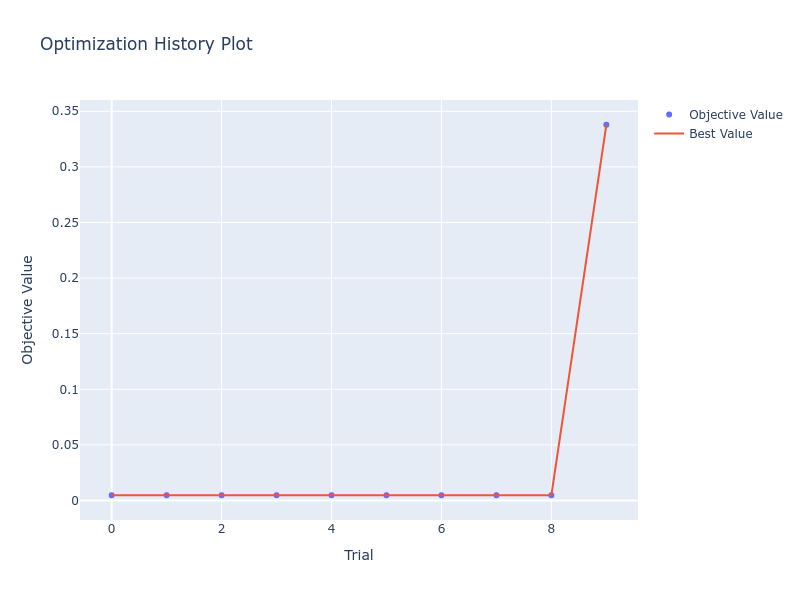

In [19]:
from optuna.visualization import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
)
import plotly.io as pio
from IPython.display import Image, display

fig = plot_optimization_history(grid_pipelin._study)
# Convertir a PNG en memoria
img_bytes = pio.to_image(fig, format="png", width=800, height=600)
# Mostrar en el notebook
display(Image(data=img_bytes))

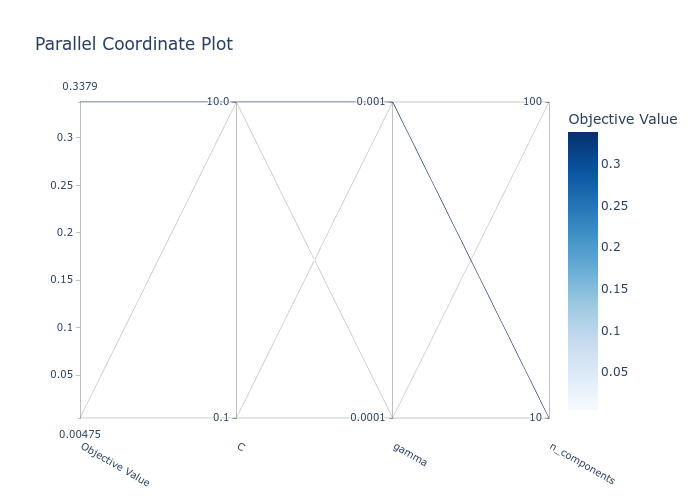

In [21]:
display(Image(data=pio.to_image(plot_parallel_coordinate(grid_pipelin._study))))

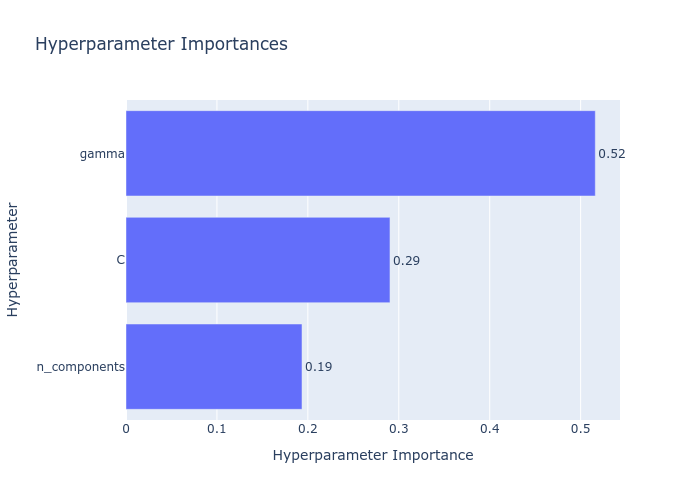

In [22]:
display(Image(data=pio.to_image(plot_param_importances(grid_pipelin._study))))

This is awesome right, this dashboard can be accessed in your browser at http://localhost:8080/